# Future weather models 

Create synthetic future weather data up to 2100 by using climate projections by DWD: 

https://www.dwd.de/DE/klimaumwelt/klimaatlas/klimaatlas_node.html;jsessionid=D84E870D1392681BE23498BDEFDD6364.live11043

1. Baseline model: no change relative to 1971-2000 average
2. Reserved model: slight changes
3. T-model: only T-changes, pronounced
4. P-model: only P-changes, pronounced
5. Mid model: Intermediate changes in P and T
6. Worst-case model: Extreme changes in P and T

Always calculate anomalies relative to baseline model.

In [1]:
from toolbox import *

import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
import pickle

In [2]:
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

pd.set_option('display.max_rows', 100)


## Load data

In [3]:
w = pd.read_csv('./data/weather_collections/weather_daily_region.csv')

# change date column to datetime type
w.date = pd.to_datetime(w.date)

# restrict data to the reference period 1971-2000
w = w.loc[w['date'] >= pd.to_datetime('1971-01-01')]
w = w.loc[w['date'] <= pd.to_datetime('2000-12-31')]

# set datetime index
w.set_index('date', inplace=True)
#w['date'] = w.index
w

,station_id_count,precip_mean,precip_min,precip_max,precip_std,tmean_mean,tmean_min,tmean_max,tmean_std,tmax_mean,...,tmax_max,tmax_std,tmin_mean,tmin_min,tmin_max,tmin_std,moisture_mean,moisture_min,moisture_max,moisture_std
date,,,,,,,,,,,,,,,,,,,,,
1971-01-01,7,0.028571,0.0,0.2,0.075593,-11.385714,-13.5,-10.2,1.175342,-6.228571,...,-4.4,1.443046,-14.471429,-17.5,-12.7,1.715337,83.000000,80.0,87.0,3.162278
1971-01-02,7,0.400000,0.0,1.0,0.424264,-8.042857,-9.3,-7.4,0.723089,-6.257143,...,-5.5,0.475595,-14.828571,-17.5,-12.1,1.829129,82.333333,79.0,88.0,3.076795
1971-01-03,7,0.757143,0.2,2.0,0.618755,-5.857143,-6.5,-4.7,0.699660,-4.628571,...,-2.7,1.338798,-8.242857,-10.1,-7.3,1.008063,86.500000,84.0,93.0,3.271085
1971-01-04,7,0.128571,0.0,0.5,0.179947,-5.414286,-6.2,-4.7,0.636209,-4.057143,...,-2.5,0.832380,-6.171429,-7.3,-5.2,0.809762,88.000000,84.0,94.0,3.794733
1971-01-05,7,0.000000,0.0,0.0,0.000000,-9.100000,-12.7,-7.3,1.940790,-5.414286,...,-4.0,0.971989,-11.357143,-15.0,-8.6,2.428894,87.666667,85.0,91.0,2.658320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-12-27,5,1.320000,0.0,1.9,0.828855,4.520000,4.0,5.2,0.540370,6.820000,...,8.2,0.861394,1.360000,0.2,2.6,1.080740,95.000000,93.0,98.0,2.000000
2000-12-28,5,0.060000,0.0,0.2,0.089443,3.100000,0.0,4.3,1.752142,5.920000,...,6.8,0.653452,1.260000,-1.5,2.7,1.697940,78.200000,71.0,90.0,7.596052
2000-12-29,5,4.280000,3.0,6.5,1.347961,0.160000,-1.4,1.0,0.928978,2.560000,...,3.9,1.663731,-1.060000,-2.1,0.0,0.756968,95.200000,92.0,97.0,1.923538


<Axes: xlabel='date', ylabel='tmean_mean'>

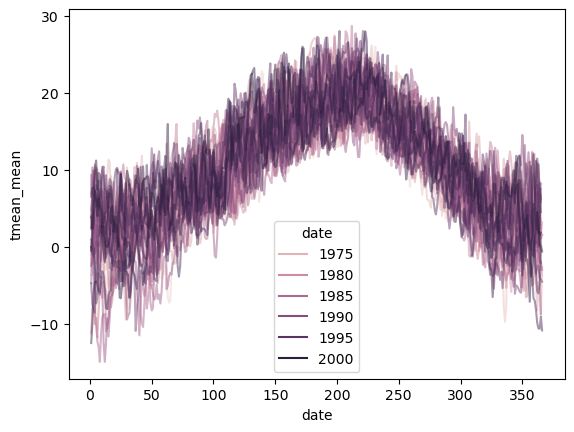

In [4]:
sns.lineplot(data=w, x=w.index.dayofyear, y='tmean_mean',
             hue=w.index.year,
             alpha=0.5)
#plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31'))
#plt.xlim(0,365)

## Create reference year from average

First iteration only with average values. Later try more elaborate calculations.

In [5]:
ref_year = w.groupby(by=[w.index.month.rename('month'),
                         w.index.day.rename('day')]
                    ).agg({'precip_mean': 'mean',
                          'moisture_mean': 'mean',
                          'tmean_mean': 'mean',
                          'precip_std': 'std',
                          'moisture_std': 'std',
                          'tmean_std': 'std',})

ref_year.reset_index(inplace=True)

In [6]:
ref_year['month'] = ref_year['month'].astype(str).str.zfill(2)
ref_year['day'] = ref_year['day'].astype(str).str.zfill(2)
ref_year['month_day'] = ref_year['month'] + '-' + ref_year['day']

In [7]:
#ref_year.info()

In [8]:
#ref_year['precip_mean']

In [9]:
#ref_year['precip_std'].quantile(0.05)#.median()

## Create scenario: Reference year, no drift

In [10]:
s_name = 'avg_t0_p0' # name for this scenario
start_year = 2000
years_range = range(0,50)

# following values from DWD Klimaatlas
# https://www.dwd.de/DE/klimaumwelt/klimaatlas/
y2y_t_change = 0#2/100 # °C absolute change per year
y2y_p_change = 0#0.1/100 # relative change per year

s_list = []

for year in years_range:
    s = create_weather(ref_year, start_year, year, y2y_t_change, y2y_p_change, add_rand=True)
    s_list.append(s)

In [11]:
s = pd.concat(s_list)
s = calc_cumulative_weather(s)
#s

In [12]:
s[s.isna().any(axis=1)]

,date,precip_mean,moisture_mean,tmean_mean,precip_std,moisture_std,tmean_std,precip_mean_prev_2d_sum,tmean_mean_prev_2d_mean,precip_mean_prev_7d_sum,tmean_mean_prev_7d_mean,precip_mean_prev_30d_sum,tmean_mean_prev_30d_mean,precip_mean_prev_90d_sum,tmean_mean_prev_90d_mean,precip_mean_prev_1y_sum,tmean_mean_prev_1y_mean,precip_mean_prev_3y_sum,tmean_mean_prev_3y_mean
date,,,,,,,,,,,,,,,,,,,
2000-01-01,2000-01-01,2.087411,84.921627,0.606267,1.122057,1.814339,0.349213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-02,2000-01-02,0.603578,86.353730,1.524896,1.543725,1.748377,0.466580,2.690989,1.065582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03,2000-01-03,2.884064,82.955595,1.890288,1.221580,1.836179,0.386965,3.487642,1.707592,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,2000-01-04,2.603531,83.210635,1.564070,2.122723,1.974659,0.466672,5.487595,1.727179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,2000-01-05,2.186207,82.913690,2.183885,1.430935,2.911046,0.497324,4.789738,1.873977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-12-25,2002-12-25,1.880131,84.379881,3.004993,1.340321,3.763263,0.590907,4.186199,2.851331,17.396706,2.738395,73.320786,2.805204,190.824022,6.327101,688.257096,10.055842,NaN,NaN
2002-12-26,2002-12-26,1.405506,85.980317,2.787861,1.072120,2.095161,0.483725,3.285638,2.896427,16.954893,2.788953,73.339426,2.793968,191.624986,6.210070,688.942890,10.058051,NaN,NaN
2002-12-27,2002-12-27,1.053456,83.405556,3.346153,1.444886,1.511458,0.448116,2.458962,3.067007,12.769737,2.881715,72.526846,2.799394,191.781295,6.102949,688.272830,10.060268,NaN,NaN


(10957.0, 12417.0)

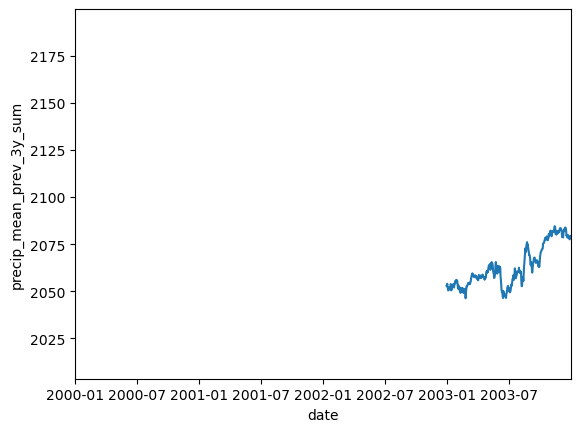

In [13]:
sns.lineplot(data=s, x='date', y='precip_mean_prev_3y_sum')
plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2003-12-31'))

### Reduce to weekly data

In [14]:
s = s[s.index.dayofweek == 0]
#s

(10957.0, 11322.0)

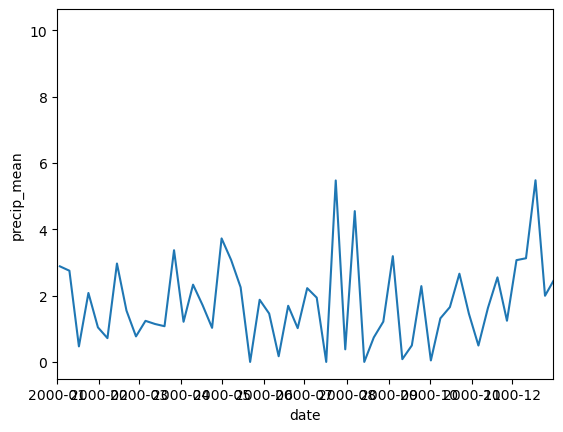

In [15]:
sns.lineplot(data=s, x='date', y='precip_mean')
plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31'))

### Save scenario to file

In [16]:
if True:
    s.to_csv(f'./data/weather_future/{s_name}.csv', index=False)

## Create scenario: From reference year, strong pos drift

In [17]:
s_name = 'avg_t+4_p+10' # name for this scenario
start_year = 2000
years_range = range(0,50)

# following values from DWD Klimaatlas
# https://www.dwd.de/DE/klimaumwelt/klimaatlas/
y2y_t_change = 4/100 # °C absolute change per year
y2y_p_change = 0.1/100 # relative change per year

s_list = []

for year in years_range:
    s = create_weather(ref_year, start_year, year, y2y_t_change, y2y_p_change, add_rand=True)
    s_list.append(s)

In [18]:
s = pd.concat(s_list)
s = calc_cumulative_weather(s)
#s

<Axes: xlabel='date', ylabel='tmean_mean'>

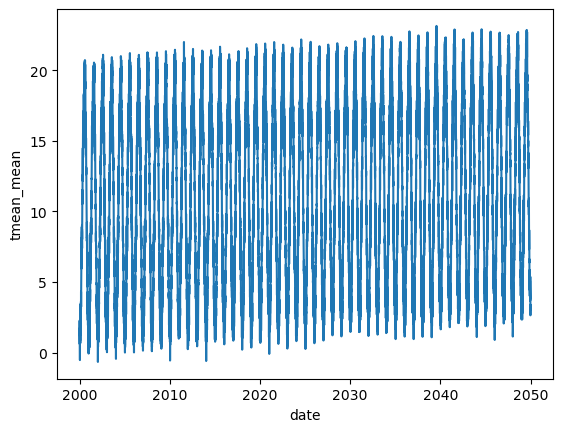

In [19]:
sns.lineplot(data=s, x='date', y='tmean_mean')
#plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31'))

### Reduce to weekly data

In [20]:
s = s[s.index.dayofweek == 0]
#s

(10957.0, 11322.0)

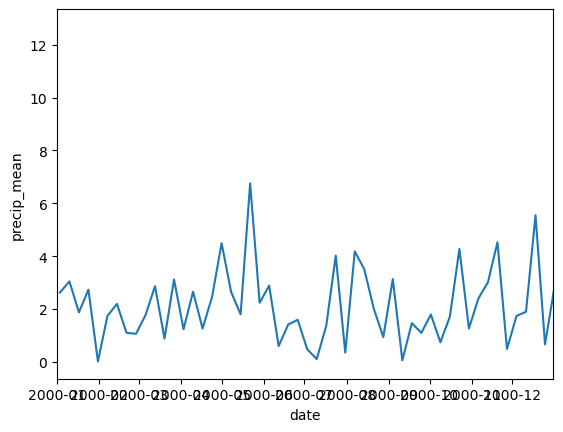

In [21]:
sns.lineplot(data=s, x='date', y='precip_mean')
plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31'))

### Save scenario to file

In [22]:
if True:
    s.to_csv(f'./data/weather_future/{s_name}.csv', index=False)

## Create scenario: From reference year, weak pos drift

In [23]:
s_name = 'avg_t+2_p+05' # name for this scenario
start_year = 2000
years_range = range(0,50)

# following values from DWD Klimaatlas
# https://www.dwd.de/DE/klimaumwelt/klimaatlas/
y2y_t_change = 2/100 # °C absolute change per year
y2y_p_change = 0.05/100 # relative change per year

s_list = []

for year in years_range:
    s = create_weather(ref_year, start_year, year, y2y_t_change, y2y_p_change, add_rand=True)
    s_list.append(s)

In [24]:
s = pd.concat(s_list)
s = calc_cumulative_weather(s)
#s

<Axes: xlabel='date', ylabel='tmean_mean'>

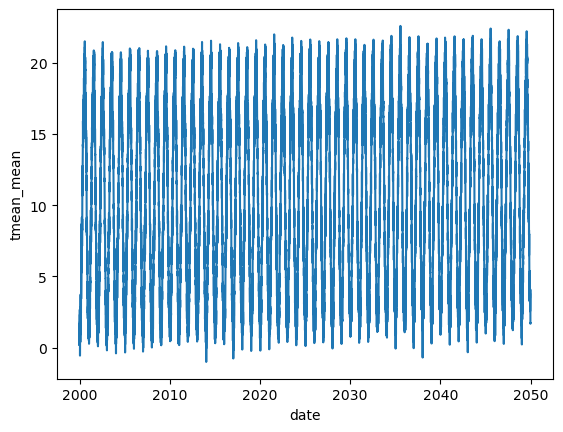

In [25]:
sns.lineplot(data=s, x='date', y='tmean_mean')
#plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31'))

### Reduce to weekly data

In [26]:
s = s[s.index.dayofweek == 0]
#s

(10957.0, 11322.0)

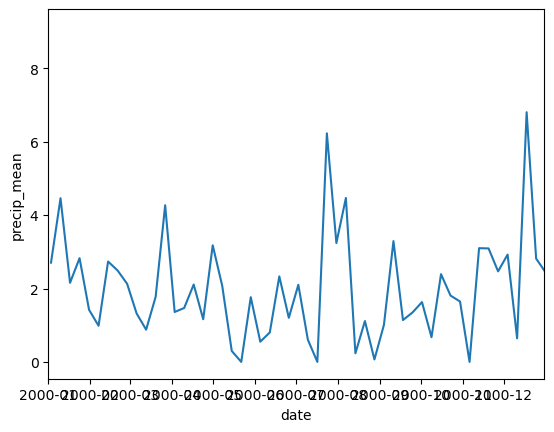

In [27]:
sns.lineplot(data=s, x='date', y='precip_mean')
plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31'))

### Save scenario to file

In [28]:
if True:
    s.to_csv(f'./data/weather_future/{s_name}.csv', index=False)

## Create scenario: From ref year, +T, -P

In [29]:
s_name = 'avg_t+4_p-10' # name for this scenario
start_year = 2000
years_range = range(0,50)

# following values from DWD Klimaatlas
# https://www.dwd.de/DE/klimaumwelt/klimaatlas/
y2y_t_change = 4/100 # °C absolute change per year
y2y_p_change = -0.1/100 # relative change per year

s_list = []

for year in years_range:
    s = create_weather(ref_year, start_year, year, y2y_t_change, y2y_p_change, add_rand=True)
    s_list.append(s)

In [30]:
s = pd.concat(s_list)
s = calc_cumulative_weather(s)
#s

<Axes: xlabel='date', ylabel='tmean_mean'>

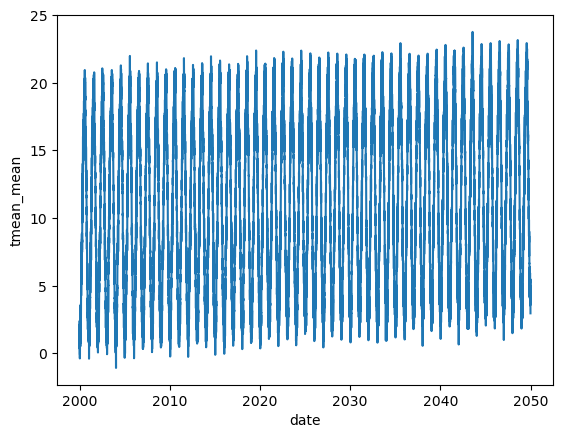

In [31]:
sns.lineplot(data=s, x='date', y='tmean_mean')
#plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31'))

### Reduce to weekly data

In [32]:
s = s[s.index.dayofweek == 0]
#s

(10957.0, 11322.0)

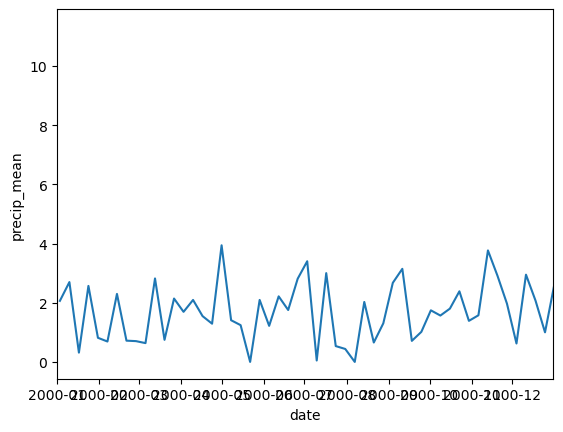

In [33]:
sns.lineplot(data=s, x='date', y='precip_mean')
plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31'))

### Save scenario to file

In [34]:
if True:
    s.to_csv(f'./data/weather_future/{s_name}.csv', index=False)

## Create scenario: From ref year, -T, +P

In [35]:
s_name = 'avg_t-4_p+10' # name for this scenario
start_year = 2000
years_range = range(0,50)

# following values from DWD Klimaatlas
# https://www.dwd.de/DE/klimaumwelt/klimaatlas/
y2y_t_change = -4/100 # °C absolute change per year
y2y_p_change = 0.1/100 # relative change per year

s_list = []

for year in years_range:
    s = create_weather(ref_year, start_year, year, y2y_t_change, y2y_p_change, add_rand=True)
    s_list.append(s)

In [36]:
s = pd.concat(s_list)
s = calc_cumulative_weather(s)
#s

<Axes: xlabel='date', ylabel='tmean_mean'>

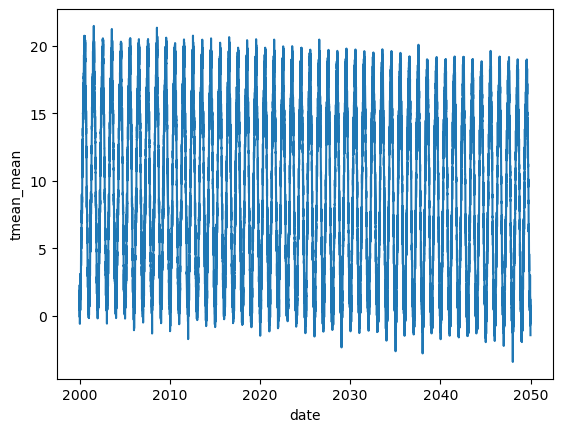

In [37]:
sns.lineplot(data=s, x='date', y='tmean_mean')
#plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31'))

### Reduce to weekly data

In [38]:
s = s[s.index.dayofweek == 0]
#s

(10957.0, 11322.0)

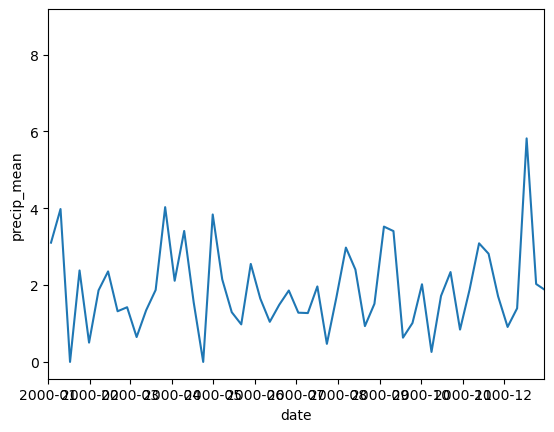

In [39]:
sns.lineplot(data=s, x='date', y='precip_mean')
plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31'))

### Save scenario to file

In [40]:
if True:
    s.to_csv(f'./data/weather_future/{s_name}.csv', index=False)